**Linear Autoencoder using MNIST**

In this code, we are going to implement step-by-step a Linear AutoEncoder, which is equivalent to PCA. If you have any questions, you can contact the instructor.

The first thing we need to do is to import the necessary libraries. We will use numpy, matplotlib, torch, tqdm and torchvision to load the dataset. We will also use the magic command `%matplotlib inline` to show the plots in the notebook. Note that we also seed the code for reproducibility.

In [20]:
# Code adapted from https://github.com/plaut/linear-ae-pca/blob/master/LinearAE_PCA_MNIST.py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.datasets as datasets
%matplotlib inline

# Seed for reproducibility
rng = np.random.default_rng(1234)
_ = torch.manual_seed(1234)

Now, we are going to define the Linear AutoEncoder class. The encoder and decoder will have a single layer each, and the activation function will be linear.

In [21]:
# Linear Autoencoder
class LinearAE(nn.Module):
  def __init__(self, input_dim=784, latent_dim=16, learning_rate=1e-4, regularization=5e-4):
    super(LinearAE, self).__init__()  # Call the __init__ function of nn.Module
    self.encoder = nn.Linear(input_dim, latent_dim)  # Encoder layer
    self.decoder = nn.Linear(latent_dim, input_dim)  # Decoder layer

  def encode(self, x):  # Encode method, to obtain the latent representation
    return self.encoder(x)

  def decode(self, x): # Decode method, to reconstruct from the latent representation
    return self.decoder(x)

  def forward(self, x):  # Forward pass
    z = self.encode(x)
    x = self.decode(z)
    return x

  def fit(self, X_train, X_val, epochs=50, batch_size=2048):  # Method to train the AE
    optimizer = torch.optim.Adam(self.parameters())  # Adam optimizer
    criterion = nn.MSELoss()  # MSE loss
    train_losses = []  # List to store the training loss
    val_losses = []  # List to store the validation loss

    for epoch in tqdm(range(epochs)):  # Loop over the epochs
      epoch_tr_loss = []  # List to store the loss of each batch
      for i in range(0, X_train.shape[0], batch_size):  # Loop over the batches
        x = X_train[i:i + batch_size] # Get the batch
        x_hat = self.forward(x)  # Forward pass
        loss = criterion(x_hat, x)  # Compute the loss
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        epoch_tr_loss.append(loss.item())  # Append the loss to the list
      train_losses.append(np.mean(epoch_tr_loss))  # Append the average loss of the epoch to the list

      with torch.no_grad():  # We don't need gradients for validation
        x = X_val  # Get the validation data
        x_hat = self.forward(x)  # Forward pass
        loss = criterion(x_hat, x)  # Compute the loss
        val_losses.append(loss.item())  # Append the loss to the list

    return train_losses, val_losses  # Return the losses

Now, we are going to load the MNIST dataset. We will use the `datasets` module from `torchvision` to load the dataset. We will also convert the images to vectors and normalize them to be in the [0, 1] range.

In [22]:
# Load MNIST data
mnist_tr_set = datasets.MNIST(root='./D_set', train=True, download=True, transform=None)  # Training set
mnist_ts_set = datasets.MNIST(root='./D_set', train=False, download=True, transform=None)  # Test set
train_data = torch.reshape(mnist_tr_set.data, (mnist_tr_set.data.shape[0], 784)).float() / 255  # Convert images to vectors and make them be in [0, 1] range
test_data = torch.reshape(mnist_ts_set.data, (mnist_ts_set.data.shape[0], 784)).float() / 255  # Convert images to vectors and make them be in [0, 1] range

We are ready to train the Linear AutoEncoder. We will use 100 dimensions for the latent representation, and we will train the AE for 50 epochs. We will use a batch size of 2500.

In [23]:
dimension = 100  # Latent dimension to be used
print('Training Linear AE...')
linear_ae = LinearAE(latent_dim=dimension)
train_loss, val_loss = linear_ae.fit(train_data, test_data, epochs=50, batch_size=2500)

Training Linear AE...


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


Finally, we are going to plot the training and validation losses, which show that the AE has succesfully converged.

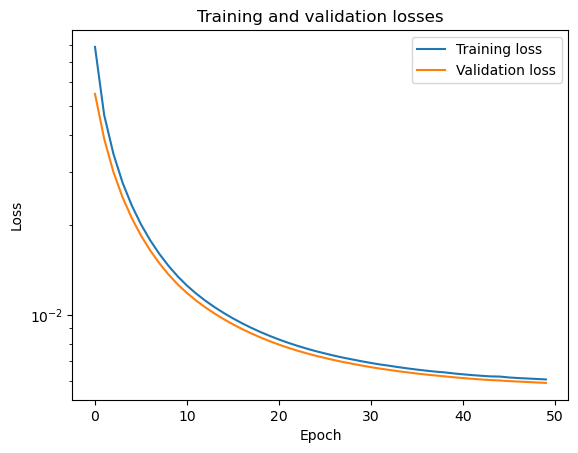

In [24]:
# Plot the training and validation losses
plt.semilogy(train_loss, label='Training loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

Finally, we are going to study the latent representation of the AE. We will show the first 5 images of the test set, and we will reconstruct them using different number of dimensions of the latent space. We will use 25%, 50%, 75% and 100% of the dimensions. Note that the latent representation is a vector of 100 dimensions, so we will set to 0 the last 75, 50 and 25 dimensions, respectively. As you can see, the more dimensions we use, the better the reconstruction is.

A final note is required relating the performance of the Linear AE with PCA. These two are equals, but the Linear AE is trained using gradient descent, while PCA is trained using the eigendecomposition of the covariance matrix. Also, the Linear AE can be extended to non-linear AEs, while PCA cannot. However, if you wanted to compare PCA and the Linear AE, you would have to order the eigenvectors of the covariance matrix by their eigenvalues, and then compare the eigenvectors of the covariance matrix with the columns of the encoder matrix of the Linear AE. You would see that they are the same, but in different order, and you do need this order to be the same to compare both methods.

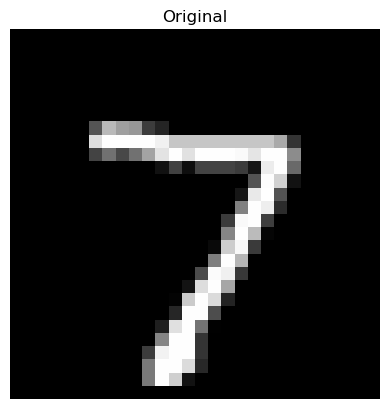

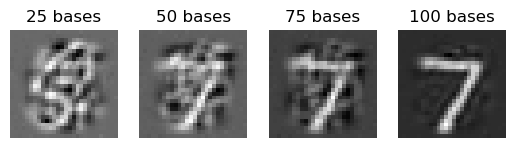

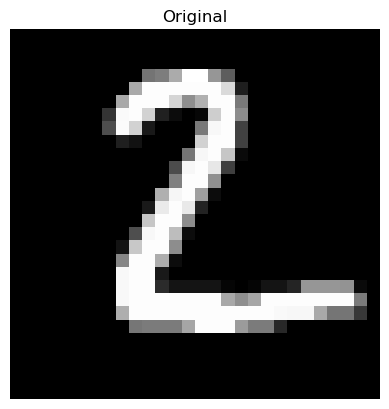

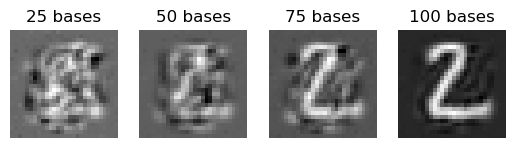

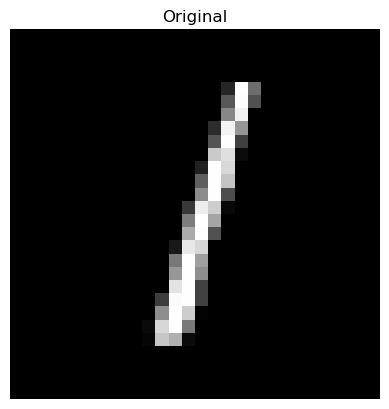

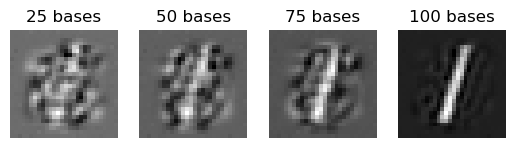

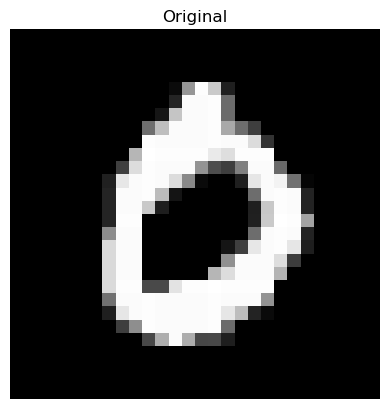

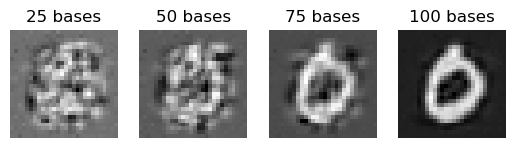

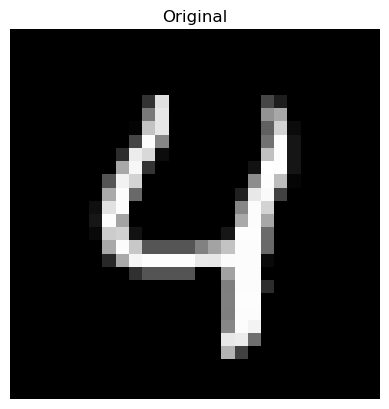

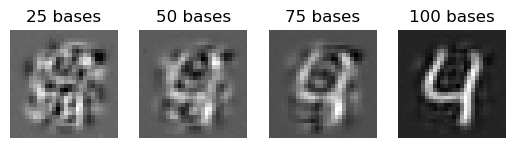

In [25]:
n_imgs = 5  # Number of sample images to show
for i in range(n_imgs):
  img = mnist_ts_set.data[i].float()  # Select an image
  plt.imshow(img.numpy(), cmap='gray')
  plt.title('Original')
  plt.axis('off')
  plt.show()

  latent_img = linear_ae.encode(img.reshape([1, 784]))  # Encode the image: this is the latent representation
  p = [0.25, 0.5, 0.75, 1]  # Proportions to be shown
  plt.figure()
  for j, prop in enumerate(p):
    rec_dim = int(np.ceil(prop * dimension))
    lat_img = torch.clone(latent_img)
    lat_img[:, rec_dim:] = 0.0
    rec_img = linear_ae.decode(lat_img).reshape([28, 28]).detach().numpy()  # Decode using only the first rec_dim dimensions
    plt.subplot(1, len(p), j + 1)
    plt.imshow(rec_img, cmap='gray')
    plt.title(str(rec_dim) + ' bases')
    plt.axis('off')
  plt.show()